# Closest venues in the city
#### Enrique Gámez Flores
#### Coursera Capstone Project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

A simple generic user program to make recommendations about geographical clusters of certain venues in a selected city, or location, is presented.

Imagine that you are planning a trip to a certain city to explore the jazz scene , but you don’t want to move so much around and want to explore the possibility to find as much as jazz clubs you can, and a hotel, or hostel, to stay there and all nearby (example 1 in this report). Or imagine that you are willing to open a yoga center, or anything else, but you want to make sure that either there is no yoga center around (example 2 in this report) or there few of them, but in any case all the candidate places are surrounded by certain kinds of stores, so, you want to know how many places, with such conditions, are in the city.

In all the aforementioned cases you are willing to get some recommendations about those locations.

All this can be accomplished with the same method, with the use of a particular machine learning algorithm, runned over data provided by the Foursquare Places service, in a simpler way.

This solution can be used by travel agencies, to offer personalized experiences, entrepreneurs who like to  evaluate new locations, or anyone who is planning a trip.

## Data <a name="data"></a>

To generate such recommendations we will make use of the Foursquare Places service, for venue discovery, and the final user requirements.

### User requirements
From the final user we require:
- the location to search for, either by its geographical coordinates or by a geolocation string,
- the categories (according to the Foursquare Places Categories already defined), and
- a set of flags about a certain kind of venue must be, or must not be, in the final recommendation

The flags mentioned are to create a simple rule and it is only used in the final part of the full procedure, and it is used for discrimination pourposes. This rule is passed as a list of tuples, and each tuple consists of a venue category name (according to the Foursquare  categories) and an integer, and it is precisely this integer the one used to characterize how much a venue type is wanted, and their possible values are:
* 2, if a venue type must be in the final recommendation,
* 1, if a venue type may appear,
* 0, if a venue type could possibly appear also,
* -1 if a venue must appear in the final recommendation when  a venue with value -2 is excluded
* -2 if a venue needs to be excluded in the final answer but venues with a value of -1 must be in

Lets define two example applications:

In [1]:
# Example 1, my home town
city = 'Puebla de Zaragoza, Mexico'
venues_wanted = [('Jazz Club', 2), ('Hotel', 1), ('Hostel', 0)]

# Example 2
#city = 'Geneva, Switzerland'
#venues_wanted = [('Yoga Studio', -2), ('Ice Cream Shop', -1), ('Spa', 0)]

Import the some of the required libraries

In [2]:
import numpy as np
import pandas as pd
import requests
from geopy.geocoders import Nominatim
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

But first we define our Foursquare access keys

In [3]:
CLIENT_ID = 'YOUR-FOURSQUARE-ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR-FOURSQUARE-SECRET' # your Foursquare Secret
VERSION = '20200304'

The available categories will be those already defined in the Foursquare Global Database Places API, so we first need to provide the available categories, so we need to make available the categories.

To do so, the API already provides an endpoint to retrieve this data.

Now we define a couple of functions to convert the Foursquare categories to a dataframe

In [4]:
def depth(data, names):
    """Function to be used to recursively traverse the dictionary with all
       the Foursquare categories
       data     dictionary
       names    list where to put the category names
    """
    for c in data['categories']:
        names.extend([(c['id'], c['name'])])
        # Search for more categories beneath
        if 'categories' in c:
            depth(c, names)



def get_categories():
    """Returns a dataframe with all the available categories"""
    url = 'https://api.foursquare.com/v2/venues/categories?' \
          '&client_id={}&client_secret={}&v={}'.\
          format(CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    if results['meta']['code'] == 400:
        return None
    categories = []
    depth(results['response'], categories)

    if len(categories):
        df = pd.DataFrame(categories)
        df.columns = ["Id", "Name"]
    return df

Retrieve the categories, and show a little bit of them

In [5]:
categories = get_categories()
categories.head(10)

,Id,Name
0,4d4b7104d754a06370d81259,Arts & Entertainment
1,56aa371be4b08b9a8d5734db,Amphitheater
2,4fceea171983d5d06c3e9823,Aquarium
3,4bf58dd8d48988d1e1931735,Arcade
4,4bf58dd8d48988d1e2931735,Art Gallery
5,4bf58dd8d48988d1e4931735,Bowling Alley
6,4bf58dd8d48988d17c941735,Casino
7,52e81612bcbc57f1066b79e7,Circus
8,4bf58dd8d48988d18e941735,Comedy Club
9,5032792091d4c4b30a586d5c,Concert Hall


Retrieve a single category by its Foursquare Id

In [6]:
categories[categories.Id == '4bf58dd8d48988d1c9941735']

,Id,Name
234,4bf58dd8d48988d1c9941735,Ice Cream Shop


With the above information, and the place given by the user we now are able to retrieve all the desired venues in the place given. The following function will retrive the venues, one at a time, and put it onto a dataframe

In [7]:
def split_categories(categories_list):
    """Function to """
    wgt = []
    ids = []
    for c in categories_list:
        # Search for its foursquare Id
        ids.append(categories.loc[categories.Name == c[0], 'Id'].values[0])
        wgt.append(c[1])

    return ids, wgt


def get_all_venues(url, wanted):
    """Function to retrieve all the Foursquare Places venues"""
    # Start by retrieving the venues, once, to get the initial parameters
    venues_list = None
    latitude = None
    longitude = None

    results = requests.get(url).json()

    # Check the response
    if results['meta']['code'] == 400:
        # An error ocurred
        return None, None, None

    # Get the total number of venues in this category
    n = 0
    if 'totalResults' in results['response']:
        n = results['response']['totalResults']


    # And the main request Id
    requestId = results['meta']['requestId']

    # Get the main coordinates from Foursquare
    if 'geocode' in results['response']:
        latitude = results['response']['geocode']['center']['lat']
        longitude = results['response']['geocode']['center']['lng']

    venues_list = []
    k = 1
    while True:
        # Parse the result dictionary and convert it to a usable dataframe
        for v in results['response']['groups'][0]['items']:
            venues_list.append((
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name'],
                ', '.join(v['venue']['location']['formattedAddress']),
                wanted))

        if float(len(venues_list)) < float(n) * .9:
            # We need to continue
            # We need to get more venues with the requestId appendded
            url += '&requestId={}&offset={}'.format(requestId, k*100)
            results = requests.get(url).json()
            k += 1
        else:
            break


    return venues_list, latitude, longitude




def explore_venues(categories_list, place=None,
                   latitude=None, longitude=None, limit=100, radius=5000):
    """Function to retrieve venues, from selected categories near
       to the given place
           categories    List of categories in the Foursquare API
           place         Geolocation string indicating the place of choice
           latitude      latitude
           longitude     longitude
        Returns
           A dataframe with all the venues
           latitude of the place
           longitude of the place
    """
    # Check the arguments given
    base_url = 'https://api.foursquare.com/v2/venues/explore?limit={}' \
               '&client_id={}&client_secret={}&v={}&radius={}'.\
               format(limit, CLIENT_ID, CLIENT_SECRET, VERSION, radius)

    if place is not None:
        base_url += '&near={}'.format(place)
    elif latitude is not None and longitude is not None:
        base_url += '&ll={},{}'.format(latitude, longitude)
    else:
        return None, None, None

    i = 0
    venues_list = []
    lat = latitude
    lng = longitude
    cats, wanted = split_categories(categories_list)
    for category in cats:
        url = base_url + '&categoryId={}'.format(category)

        # Now we are ready to retrive all the venues
        v_list, lat, lng = get_all_venues(url, wanted[i])
        venues_list.extend(v_list)
        i += 1

    nearby_venues = None
    if len(venues_list):
        nearby_venues = pd.DataFrame(venues_list)
        nearby_venues.columns = ['Venue', 'Latitude','Longitude', 'Category',
                                 'FormattedAddress', 'Wanted']
    
    return nearby_venues, lat, lng

Foursquare Places _explore_ endpoint can retrieve venues near a geostring location, but it may be better to use geographical coordinates, so we will use the package _geopy_

Plug the geostring to retrieve its geographical coordinates

In [8]:
geolocator = Nominatim(user_agent="capstone_foursquare_agent01")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude
print('Latitude:', latitude, 'Longitude:', longitude)

Latitude: 19.0437227 Longitude: -98.1984744


We are now ready to explore the venues that meet such conditions

In [9]:
venues, _, _ = explore_venues(venues_wanted,
                                  latitude=latitude, longitude=longitude,
                                  radius=12000)
venues.head()

,Venue,Latitude,Longitude,Category,FormattedAddress,Wanted
0,Jazzatlán,19.060994,-98.303229,Jazz Club,"2 Oriente 406, 72760 San Pedro Cholula, Puebla...",2
1,sayuri,19.044346,-98.150481,Jazz Club,México,2
2,Festival Co-mu-co,19.067719,-98.279270,Jazz Club,"Container City, San Andres De Cholula, Puebla,...",2
3,La Purificadora,19.044183,-98.190885,Hotel,Callejón 10 Norte 802 (Blvd. Héroes del 5 de M...,1
4,Hotel Descansería Business And Pleasure,19.040498,-98.194037,Hotel,3 Oriente 627 (Esq. con Blvd. Héroes del 5 de ...,1


How many venues were retrieved acording the user needs, show them as a dataframe

In [10]:
venues.groupby('Wanted').count()[['Venue']]

,Venue
Wanted,
0,6
1,154
2,3


How many categories we have

In [11]:
venues.groupby('Category').count()[['Venue']]

,Venue
Category,
Bar,1
Bed & Breakfast,6
Hostel,10
Hotel,137
Hotel Pool,1
Jazz Club,3
Motel,4
Veterinarian,1


Let's plot the venues

In [12]:
place_map = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, category, venue in zip(venues['Latitude'], venues['Longitude'], venues['Category'], venues['Venue']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(place_map)

place_map

To used the KMeans we need only the geographical coordinates, so we must prepare a dataframe with that information only.

In [13]:
X = venues[['Latitude', 'Longitude']].values
X[0:5]

array([[ 19.06099418, -98.30322862],
       [ 19.04434593, -98.15048067],
       [ 19.06771918, -98.27927014],
       [ 19.04418306, -98.19088516],
       [ 19.04049819, -98.19403727]])

## Methodology <a name="methodology"></a>

To produce the desired output, we first need to determine geographical clusters, so we will use KMeans for this task.

But first we may need to know into how many number of clusters does all the venues retrieve fits well

In [14]:
# Check if we need to know in advance how many clusters do we need
minimum_clusters = 5
for w in venues_wanted:
    if w[1] < 0:
        # Yes, lets supposse that we have at least we can have more clusters
        # than venues wanted, lets count how many venues did we find
        minimum_clusters = venues[venues['Wanted'] == -2].count()[0] + 1
        break


Ks = 18
score = np.zeros((Ks - minimum_clusters))
inertia = np.zeros((Ks - minimum_clusters))
kmin = 0
for k in range(minimum_clusters, Ks):
    kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
    # Get the score
    score[k - minimum_clusters] = silhouette_score(X, kmeans.labels_)
    inertia[k - minimum_clusters] = kmeans.inertia_

Get the number of clusters

In [15]:
K = score.argmax() + minimum_clusters
# Lets by a little bit playfull
# in case that K and minimum_clusters are equal, go and create more clusters
print(K)
if K == minimum_clusters:
    K = score[1:].argmax() + minimum_clusters + 1

silhouette_score = score[K - minimum_clusters]
print('Number of clusters:', K, 'score:', silhouette_score)

13
Number of clusters: 13 score: 0.646083463473285


Plot those results

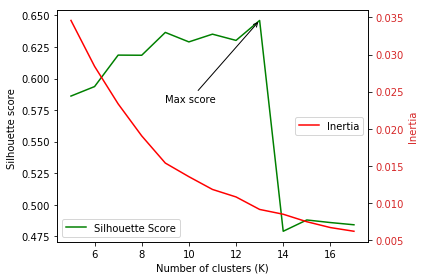

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(range(minimum_clusters, Ks), score, 'g', label='Silhouette Score')
ax1.set_ylabel('Silhouette score ')
ax1.legend(loc='best')

ax2 = ax1.twinx()
ax2.plot(range(minimum_clusters, Ks), inertia, 'r', label='Inertia')
ax2.set_ylabel('Inertia', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax1.set_xlabel('Number of clusters (K)')
ax2.legend(loc="center right")
plt.tight_layout()

# Draw an arrow to indicate the number of clusters choose
ax1.annotate("Max score", xy=(K, silhouette_score),
             xytext=(K - 4, silhouette_score*.9),
             arrowprops=dict(arrowstyle="->"))


plt.show()

From the silhouette score we observe that coulb be a good parameter to select a proper value of the number of clusters, the inertia (sum of squared distances of samples to the their closest cluster center will always decrease as the number of clusters increases, so in this type of clusters (geographical clusters) it is not a good stimator.

And now we procede to generate the clusters we are looking for

In [17]:
kmeans = KMeans(n_clusters=K, random_state=10).fit(X)

And now asociate to each venua its cluster label

In [18]:
venues.insert(0, 'Cluster', kmeans.labels_)
venues.head()

,Cluster,Venue,Latitude,Longitude,Category,FormattedAddress,Wanted
0,5,Jazzatlán,19.060994,-98.303229,Jazz Club,"2 Oriente 406, 72760 San Pedro Cholula, Puebla...",2
1,7,sayuri,19.044346,-98.150481,Jazz Club,México,2
2,0,Festival Co-mu-co,19.067719,-98.279270,Jazz Club,"Container City, San Andres De Cholula, Puebla,...",2
3,1,La Purificadora,19.044183,-98.190885,Hotel,Callejón 10 Norte 802 (Blvd. Héroes del 5 de M...,1
4,1,Hotel Descansería Business And Pleasure,19.040498,-98.194037,Hotel,3 Oriente 627 (Esq. con Blvd. Héroes del 5 de ...,1


Let's plot the clusters we found

In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues['Latitude'], venues['Longitude'], venues['Venue'], venues['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

Now we need examine each cluster and set a score for each them, in order to prepare the final answer

We need an extra function to obtain the distance between venues in meters

In [20]:
def haversine(lat1, lng1, lat2, lng2):
    """https://kanoki.org/2019/02/14/how-to-find-distance-between-two-points-based-on-latitude-and-longitude-using-python-and-sql/"""
    # convert decimal degrees to radians 
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])

    # haversine formula 
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

Define a custom score function to be associated with each cluster

In [21]:
def my_score(x):
    score = 0
    df = x['Category']
    # The following loop depends on the definition of the list *venues_wanted*
    for v in venues_wanted:
        if df.isin([v[0]]).any():
            if v[1] == 2:
                score += 500/8
            elif v[1] == 1:
                score += 200/8
            elif v[1] == 0:
                score += 100/8
            elif v[1] == -1:
                score += -200/8
            elif v[1] == -2:
                score += -500/8

    # https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters
    # Select a single most wanted venue
    mini = None
    if x[x['Wanted'].isin([2])].any().any():
        w = x[x['Wanted'] == 2][['Latitude', 'Longitude']].values[0]
        # Select all the venues which aren't the most wanted
        df2 = x[x['Wanted'] != 2][['Latitude', 'Longitude']]
        if len(df2):
            # Now computes the distances from the most wanted venue
            mini = df2.apply(haversine, args=(df2['Longitude'], w[0], w[1]))['Latitude'].min()
    return pd.Series({'score': score, 'minimum distance': mini})

Now we are ready to obtain a score for each cluster

In [22]:
scores = venues.groupby('Cluster').apply(my_score)
scores

,minimum distance,score
Cluster,,
0,0.584160,87.5
1,NaN,37.5
2,NaN,25.0
3,NaN,25.0
4,NaN,25.0
5,0.046831,100.0
6,NaN,25.0
7,1.764096,87.5
8,NaN,25.0


In this particular case we observe that three clusters satisfy the condition to find a Jazz Club near to a Hotel or a Hostel, clusters 0, 5, and 7, but the minimum geographical distance between a jazz club and a hotel or hostel is almost 2 kilometers, which may not be a good idea to give it a as good recommendation, we are going to discard it.

As for the example 2, because we are looking for clusters of stores that have no a yoga center as membser a distance cannot be computed, and for that case we only requiere maximum scores.

## Results <a name="results"></a>

Based on the numbers obtained above we choose clusters with a distance less than 1km and a score greater or equal to 87.5

Start selecting the cluster labels that meet the above criteria

In [29]:
# Example 1 selection
selection = scores[(scores['minimum distance'] < 1) & (scores['score'] >= 87.5)]

# Example 2 selection
#selection = scores[scores['score'] > 0]

# Print the selected clusters and they score
selection

,minimum distance,score
Cluster,,
0,0.584160,87.5
5,0.046831,100.0


Now select the venues for that clusters

In [30]:
selected = venues[venues['Cluster'].isin(selection.index)]

Show them

In [31]:
selected

,Cluster,Venue,Latitude,Longitude,Category,FormattedAddress,Wanted
0,5,Jazzatlán,19.060994,-98.303229,Jazz Club,"2 Oriente 406, 72760 San Pedro Cholula, Puebla...",2
2,0,Festival Co-mu-co,19.067719,-98.279270,Jazz Club,"Container City, San Andres De Cholula, Puebla,...",2
59,5,Hotel Real de Naturales,19.063926,-98.304966,Hotel,"6 Oriente 7, 72760 San Pedro Cholula, Puebla, ...",1
64,5,Hotel Posada Señorial,19.058361,-98.296263,Hotel,"Av. 5 de Mayo 1400, 72810 San Andrés Cholula, ...",1
66,5,Hotel Xelhua,19.060108,-98.304344,Hotel,"4 Sur 106, 72760 San Pedro Cholula, Puebla, Mé...",1
67,5,Hotel Terraza San Pedrito,19.052774,-98.311480,Hotel,"Av Miguel Aleman 2103 (21 Poniente), 72760 San...",1
68,0,Fiesta Inn Express,19.072702,-98.277509,Hotel,"Explanada Puebla (Priv. Alejandra 512), 72775 ...",1
70,5,Hotel Villas Arqueológicas,19.053292,-98.303668,Hotel,"13 Ote. (8 Sur), San Andrés Cholula, Puebla, M...",1
72,5,La Quinta Luna,19.060028,-98.309937,Hotel,"San Pedro Cholula, Puebla, México",1
74,5,Hotel Plaza Santa Rosa,19.062880,-98.307671,Hotel,"Portal Guerrero 5 (Plaza de la Concordia), 727...",1


Let's plot it the recommendations

In [32]:
# create map
selected_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
n = len(venues.groupby('Cluster').count())
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, address in zip(selected['Latitude'], selected['Longitude'], selected['Venue'], selected['Cluster'], selected['FormattedAddress']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + 'Address: ' + str(address), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(selected_clusters)

selected_clusters

## Discussion <a name="discussion"></a>

Querying Foursquare Places, for all the venues we seek, around a specific location  can be done in a single call, but finding certain relations can be a little more complicated, relations like spa near a business center, or finding all the possible locations of a yoga studio and an ice cream shop in the city.

We have shown a method to perform such searching tasks with the use of the Python programming language, the Pandas package to manipulate and organize the information, and machine learning algorithms for heavy computational manipulations (and, at the same time, reducing possible errors), in particular the KMeans algorithm. All this can be imagined like a giant infrastructure with some specific knobs to tune calculations and deliver the desired answer, the knobs we need to move are the pieces that make sense the data with the final answer.

Many data sources were not included, like information about the rates could enrich the recommendations, and can be simply added as a feature into the KMeans algorithm. Also some other features could be included, like real user ratings, social media comments, etc.

About the decision to not include the Inertia (closest distance) as a parameter to select a more proper number of clusters, the decision was to group as many venues as we can.

There is another important missing feature, an analytical validation procedure, i.e. no all example recommendations were verified.

## Conclusion <a name="conclusion"></a>

The use of machine learning algorithms, to solve problems that years ago could only be solved by human inspection or long, long lines of code, along with robust packages to manipulate the data collected, like the pandas library in this case, integrated on an environment written in the same programming language, let us focus only in the essentials of the problem and in how to deliver more robust answers, answers that can include a lot more data sources which adds more features to it. All this could allow us to make more accurate decisions based on more facts.

Applications like the one described it’s an example of this, a single (robust) data source, with proper analysis methods put in to the table new insights, all this augment the probability to make more accurate decisions.